In [ ]:
Why are so many diaSources getting classified as dipoles by my new DipoleFitTask code

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 999

In [50]:
!imageDifference.py calexpDir_b1631 --output decamDirTest2 --id visit=289820 ccdnum=11 --templateId visit=288976 --configfile diffimconfig.py --clobber-config --no-versions --config doSubtract=True --config doDecorrelation=True --config detection.thresholdValue=5.0

import lsst.daf.persistence as dp
if True:
    butler=dp.Butler('decamDirTest2')
    sources=butler.get('deepDiff_diaSrc',visit=289820,ccdnum=11)
    #print sources[0].extract('ip_diffim_Naive*')

if False:
# df1 will be the corrected one.
    df1 = pd.DataFrame({col: sources.columns[col] for col in sources.schema.getNames()})
    print df1.shape

(143, 158)


In [ ]:
!imageDifference.py calexpDir_b1631 --output decamDirTest2 --id visit=289820 ccdnum=11 --templateId visit=288976 --configfile diffimconfig.py --clobber-config --no-versions --config doSubtract=True --config doDecorrelation=False --config detection.thresholdValue=5.0

import lsst.daf.persistence as dp
if True:
    butler=dp.Butler('decamDirTest2')
    sources=butler.get('deepDiff_diaSrc',visit=289820,ccdnum=11)
    #print sources[0].extract('ip_diffim_Naive*')

if False:
# df2 will be the uncorrected one.
    df2 = pd.DataFrame({col: sources.columns[col] for col in sources.schema.getNames()})
    print df2.shape


In [51]:
import cPickle
import gzip

if True:
    # Now let's save them out...
    cPickle.dump((df1, df2), gzip.GzipFile('twoCatalogs2.p.gz', 'wb'))

df1, df2 = cPickle.load(gzip.GzipFile('twoCatalogs2.p.gz', 'rb'))
print df1.shape, df2.shape, float(df2.shape[0])/float(df1.shape[0]), 395./float(df1.shape[0])
#print df1.columns.values

sizeme(df1.head())

(50, 158) (143, 158) 2.86 7.9


,base_CircularApertureFlux_12_0_flag,base_CircularApertureFlux_12_0_flag_apertureTruncated,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flag,base_CircularApertureFlux_17_0_flag_apertureTruncated,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flag,base_CircularApertureFlux_25_0_flag_apertureTruncated,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flag,base_CircularApertureFlux_35_0_flag_apertureTruncated,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_50_0_flag,base_CircularApertureFlux_50_0_flag_apertureTruncated,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_70_0_flag,base_CircularApertureFlux_70_0_flag_apertureTruncated,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_GaussianCentroid_flag,base_GaussianCentroid_flag_noPeak,base_GaussianCentroid_flag_resetToPeak,base_GaussianCentroid_x,base_GaussianCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_resetToPeak,base_NaiveCentroid_x,base_NaiveCentroid_y,base_PeakCentroid_flag,base_PeakCentroid_x,base_PeakCentroid_y,base_PeakLikelihoodFlux_flag,base_PeakLikelihoodFlux_flux,base_PeakLikelihoodFlux_fluxSigma,base_PixelFlags_flag,base_PixelFlags_flag_bad,base_PixelFlags_flag_cr,base_PixelFlags_flag_crCenter,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_offimage,base_PixelFlags_flag_saturated,base_PixelFlags_flag_saturatedCenter,base_PixelFlags_flag_suspect,base_PixelFlags_flag_suspectCenter,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_SdssCentroid_flag,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_x,base_SdssCentroid_xSigma,base_SdssCentroid_y,base_SdssCentroid_ySigma,coord_dec,coord_ra,flags_negative,id,ip_diffim_ClassificationDipole_flag,ip_diffim_ClassificationDipole_value,ip_diffim_DipoleFit_centroid_x,ip_diffim_DipoleFit_centroid_y,ip_diffim_DipoleFit_chi2dof,ip_diffim_DipoleFit_flag,ip_diffim_DipoleFit_flag_classification,ip_diffim_DipoleFit_flag_classificationAttempted,ip_diffim_DipoleFit_flag_edge,ip_diffim_DipoleFit_flux,ip_diffim_DipoleFit_neg_centroid_x,ip_diffim_DipoleFit_neg_centroid_y,ip_diffim_DipoleFit_neg_flux,ip_diffim_DipoleFit_neg_fluxSigma,ip_diffim_DipoleFit_orientation,ip_diffim_DipoleFit_pos_centroid_x,ip_diffim_DipoleFit_pos_centroid_y,ip_diffim_DipoleFit_pos_flux,ip_diffim_DipoleFit_pos_fluxSigma,ip_diffim_DipoleFit_separation,ip_diffim_DipoleFit_signalToNoise,ip_diffim_NaiveDipoleCentroid_flag,ip_diffim_NaiveDipoleCentroid_neg_flag,ip_diffim_NaiveDipoleCentroid_neg_x,ip_diffim_NaiveDipoleCentroid_neg_xSigm

Find matches between the two catalogs in RA and Dec.

In [4]:
dist = np.sqrt(np.add.outer(df1.coord_dec, -df2.coord_dec)**2. + \
               np.add.outer(df1.coord_ra, -df2.coord_ra)**2.) * 206264.806247  # convert to arcsec ?
print dist.min(), np.unravel_index(np.argmin(dist), dist.shape), dist[18,48]
print df1.iloc[18].coord_dec, df1.iloc[18].coord_ra, '\t', df2.iloc[48].coord_dec, df2.iloc[48].coord_ra
print np.sum(dist < 4.)
matches = np.where(dist < 4.)
#print matches
print dist[0,0], df1.iloc[0].coord_dec, df1.iloc[0].coord_ra, '\t', df2.iloc[0].coord_dec, df2.iloc[0].coord_ra

matches1 = df1.iloc[matches[0]]
matches2 = df2.iloc[matches[1]]

fluxes1 = matches1.base_CircularApertureFlux_50_0_flux.values
fluxes2 = matches2.base_CircularApertureFlux_50_0_flux.values

fluxSigs1 = matches1.base_CircularApertureFlux_50_0_fluxSigma.values
fluxSigs2 = matches2.base_CircularApertureFlux_50_0_fluxSigma.values

isgood = ~np.isnan(fluxes1) & ~np.isnan(fluxes2)
isgood2 = ~np.isnan(fluxes1) & ~np.isnan(fluxes2) & ~np.isnan(fluxSigs1) & ~np.isnan(fluxSigs2)

fluxes1 = fluxes1[isgood]
fluxes2 = fluxes2[isgood]
fluxSigs1 = np.sqrt(fluxSigs1[isgood2])
fluxSigs2 = np.sqrt(fluxSigs2[isgood2])

0.00160877744791 (18, 48) 0.00160877744791
-0.104489021742 2.71678934622 	-0.104489013982 2.71678934699
48
0.00597487478386 -0.104245303489 2.7156887146 	-0.104245278038 2.71568870076


[   0.95769625  592.3042533 ] [  1.62906979e-03   5.06006328e+02]
0.960712456237 0.0357790507092
[  1.15829691  16.1992777 ] [  2.20951501e-03   1.43630798e+01]
1.15937399489
[ 0.77814363  1.49927133] [ 0.03286167  3.18298983]
0.828529884488 0.12303441474


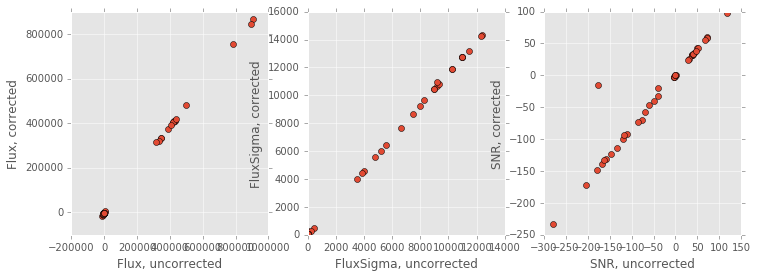

In [5]:
pars, cov = np.polyfit(fluxes2, fluxes1, deg=1, cov=True)
print pars, np.sqrt(np.diag(cov))
#print pearsonr(fluxes2, fluxes1)
print np.median(fluxes1/fluxes2), np.std(fluxes1/fluxes2)

pars, cov = np.polyfit(fluxSigs2, fluxSigs1, deg=1, cov=True)
print pars, np.sqrt(np.diag(cov))
#print pearsonr(fluxSigs2, fluxSigs1)
print np.median(fluxSigs1/fluxSigs2)

pars, cov = np.polyfit(fluxes2/fluxSigs2, fluxes1/fluxSigs1, deg=1, cov=True)
print pars, np.sqrt(np.diag(cov))
#print pearsonr(fluxSigs2, fluxSigs1)
print np.median((fluxes1/fluxSigs1)/(fluxes2/fluxSigs2)), np.std((fluxes1/fluxSigs1)/(fluxes2/fluxSigs2))

plt.figure(1, (12,4))
plt.subplot(131)
plt.plot(fluxes2, fluxes1, 'o')
plt.xlabel('Flux, uncorrected'); plt.ylabel('Flux, corrected')
#plt.ylim(-10000, 10000)
plt.subplot(132)
plt.plot(fluxSigs2, fluxSigs1, 'o')
plt.xlabel('FluxSigma, uncorrected'); plt.ylabel('FluxSigma, corrected')
plt.subplot(133)
plt.plot((fluxes2/fluxSigs2), fluxes1/fluxSigs1, 'o')
plt.xlabel('SNR, uncorrected'); plt.ylabel('SNR, corrected')
#plt.ylim(-100, 100); plt.xlim(0, 5)

In [52]:
df1.columns.values

array(['base_CircularApertureFlux_12_0_flag',
       'base_CircularApertureFlux_12_0_flag_apertureTruncated',
       'base_CircularApertureFlux_12_0_flux',
       'base_CircularApertureFlux_12_0_fluxSigma',
       'base_CircularApertureFlux_17_0_flag',
       'base_CircularApertureFlux_17_0_flag_apertureTruncated',
       'base_CircularApertureFlux_17_0_flux',
       'base_CircularApertureFlux_17_0_fluxSigma',
       'base_CircularApertureFlux_25_0_flag',
       'base_CircularApertureFlux_25_0_flag_apertureTruncated',
       'base_CircularApertureFlux_25_0_flux',
       'base_CircularApertureFlux_25_0_fluxSigma',
       'base_CircularApertureFlux_35_0_flag',
       'base_CircularApertureFlux_35_0_flag_apertureTruncated',
       'base_CircularApertureFlux_35_0_flux',
       'base_CircularApertureFlux_35_0_fluxSigma',
       'base_CircularApertureFlux_3_0_flag',
       'base_CircularApertureFlux_3_0_flag_apertureTruncated',
       'base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated',

In [53]:
print np.mean(df1.ip_diffim_DipoleFit_flag_classification.values)
print np.mean(df2.ip_diffim_DipoleFit_flag_classification.values)
print np.mean(matches1.ip_diffim_DipoleFit_flag_classification.values)
print np.mean(matches2.ip_diffim_DipoleFit_flag_classification.values)
print;
print np.mean(df1.ip_diffim_ClassificationDipole_value)
print np.mean(df2.ip_diffim_ClassificationDipole_value)
print np.mean(matches1.ip_diffim_ClassificationDipole_value)
print np.mean(matches2.ip_diffim_ClassificationDipole_value)
print;
print np.mean(df1.ip_diffim_DipoleFit_flag_classificationAttempted.values)
print np.mean(df2.ip_diffim_DipoleFit_flag_classificationAttempted.values)

0.2
0.0839160839161
0.1875
0.270833333333

0.14
0.0559440559441
0.145833333333
0.145833333333

0.2
0.0839160839161


Let's try to make the plot in Colin's DMTN-006 -- first run his script

```
python forcePhotDiaSources.py decamDirTest --output decamDirTest/ --id visit=289820 ccdnum=11 --templateId visit=288976 --no-versions
```

then...

In [31]:
import lsst.daf.persistence as dp
butler=dp.Butler('decamDirTest')
sources=butler.get('forced_src',visit=289820,ccdnum=11)
df = pd.DataFrame({col: sources.columns[col] for col in sources.schema.getNames()})
print df.shape
sizeme(df.head())

(50, 17)


,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_TransformedCentroid_flag,base_TransformedCentroid_x,base_TransformedCentroid_y,classification_dipole,coord_dec,coord_ra,diffim_base_PsfFlux_flux,diffim_base_PsfFlux_fluxSigma,objectId,parentObjectId,template_base_PsfFlux_flux,template_base_PsfFlux_fluxSigma
0,False,False,False,11402.671047,89.060454,False,1397.283325,36.974789,0,-0.104245,2.715689,NaN,NaN,124476789417312318,0,12966.984661,82.876483
1,False,False,False,17276.202225,148.566598,False,762.302063,81.918633,0,-0.103438,2.715746,-968.636060,179.460633,124476789417312319,0,19549.001016,93.088274
2,False,False,False,7450.233416,79.866487,False,461.621613,167.564728,0,-0.103056,2.715855,540.772368,115.619059,124476789417312320,0,6738.646987,67.922069
3,False,False,False,41713.357043,125.714742,False,612.939148,208.854706,0,-0.103248,2.715908,935.644564,189.519786,124476789417312321,0,39815.460800,122.876648
4,False,False,False,18078.089417,101.525175,False,780.099426,412.828247,0,-0.103460,2.716169,1237.202307,153.359418,124476789417312322,0,18540.504999,155.166339


In [9]:
df[['base_PsfFlux_flux', 'template_base_PsfFlux_flux']].head()
df['s_to_n'] = df.base_PsfFlux_flux / df.base_PsfFlux_fluxSigma
df['template_s_to_n'] = df.template_base_PsfFlux_flux / df.template_base_PsfFlux_fluxSigma
sizeme(df.head())
#sizeme(df[['s_to_n', 'template_s_to_n']].head())

,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_TransformedCentroid_flag,base_TransformedCentroid_x,base_TransformedCentroid_y,classification_dipole,coord_dec,coord_ra,diffim_base_PsfFlux_flux,diffim_base_PsfFlux_fluxSigma,objectId,parentObjectId,template_base_PsfFlux_flux,template_base_PsfFlux_fluxSigma,s_to_n,template_s_to_n
0,False,False,False,11402.671047,89.060454,False,1397.283325,36.974789,0,-0.104245,2.715689,NaN,NaN,124476789417312318,0,12966.984661,82.876483,128.032932,156.461571
1,False,False,False,17276.202225,148.566598,False,762.302063,81.918633,0,-0.103438,2.715746,-968.636060,179.460633,124476789417312319,0,19549.001016,93.088274,116.285911,210.004978
2,False,False,False,7450.233416,79.866487,False,461.621613,167.564728,0,-0.103056,2.715855,540.772368,115.619059,124476789417312320,0,6738.646987,67.922069,93.283600,99.211451
3,False,False,False,41713.357043,125.714742,False,612.939148,208.854706,0,-0.103248,2.715908,935.644564,189.519786,124476789417312321,0,39815.460800,122.876648,331.809590,324.027888
4,False,False,False,18078.089417,101.525175,False,780.099426,412.828247,0,-0.103460,2.716169,1237.202307,153.359418,124476789417312322,0,18540.504999,155.166339,178.065091,119.487933


Make a plot similar to Colin's [Figure 6 in DMTN-006](http://dmtn-006.lsst.io/en/latest/#forcephot-sci-template-v197367)

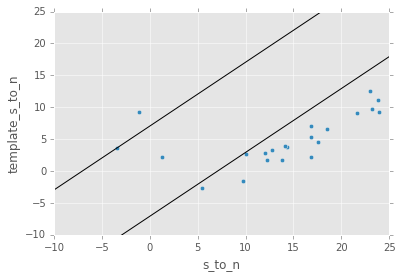

In [10]:
df.plot.scatter('s_to_n', 'template_s_to_n')
plt.xlim(-10, 25)
plt.ylim(-10, 25)
x = np.linspace(-25,25)
plt.plot(x, x-5*np.sqrt(2), 'k-')
plt.plot(x, x+5*np.sqrt(2), 'k-')

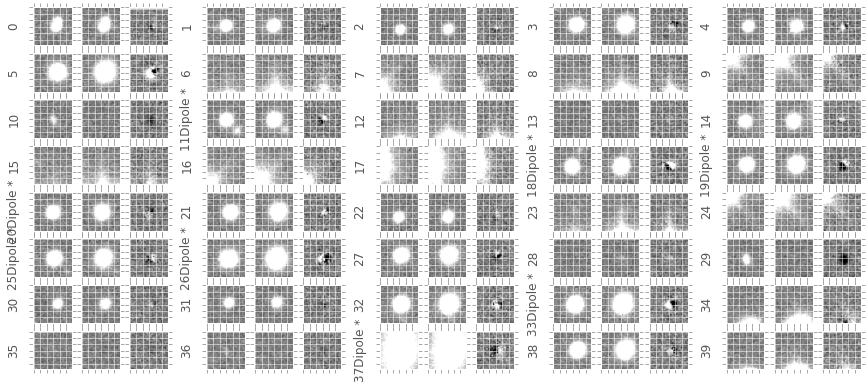

In [72]:
import diffimTests as dit
reload(dit);
plt.rcParams['figure.figsize'] = (15.0, 6.5)
dit.mosaicDIASources('decamDirTest2', visitid=289820, ccdnum=11, template_catalog={288976: [289820]}, 
                     dipoleFlag='ip_diffim_DipoleFit_flag_classification', gridSpec=[8, 5])

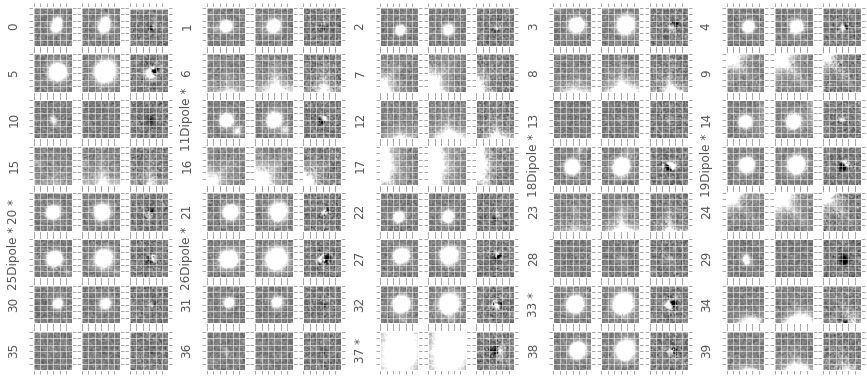

In [73]:
import diffimTests as dit
reload(dit);
plt.rcParams['figure.figsize'] = (15.0, 6.5)
dit.mosaicDIASources('decamDirTest2', visitid=289820, ccdnum=11, template_catalog={288976: [289820]}, 
                     gridSpec=[8, 5])

In [60]:
import lsst.afw.image as afwImage
diffim = afwImage.ExposureF('decamDirTest2/deepDiff/v289820/diffexp-11.fits')  # decorrelated diffim

# Also load the original science and template images
posImage = afwImage.ExposureF('calexpDir_b1631/0289820/calexp/calexp-0289820_11.fits')
negImage = afwImage.ExposureF('decamDirTest2/deepDiff/v289820/matchexp-11.fits')

124476789417312323
1


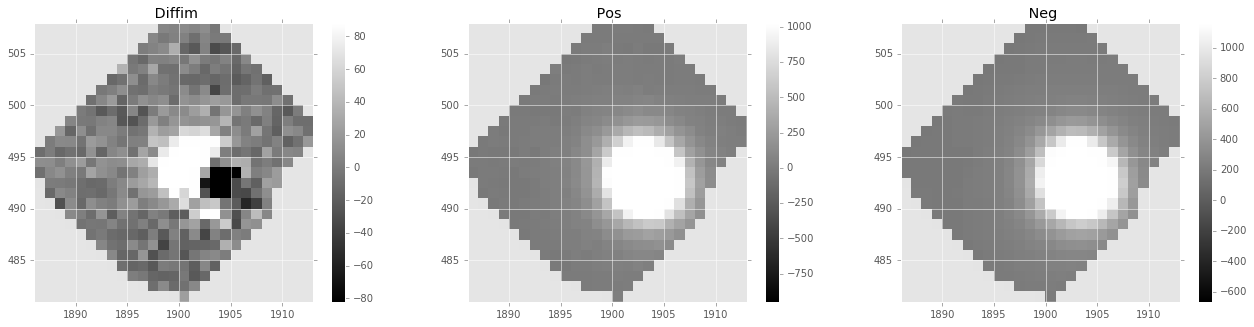

In [80]:
import lsstUtils
reload(lsstUtils)
butler = dp.Butler('decamDirTest2')
sources = butler.get('deepDiff_diaSrc', visit=289820, ccdnum=11)
source = sources[5]
print source.getId()
pks = source.getFootprint().getPeaks()
print len(pks)
fig = lsstUtils.displayCutouts(source, diffim, posImage=posImage, negImage=negImage, asHeavyFootprint=True, 
                               figsize=(22., 5.))

124476789417312321
1


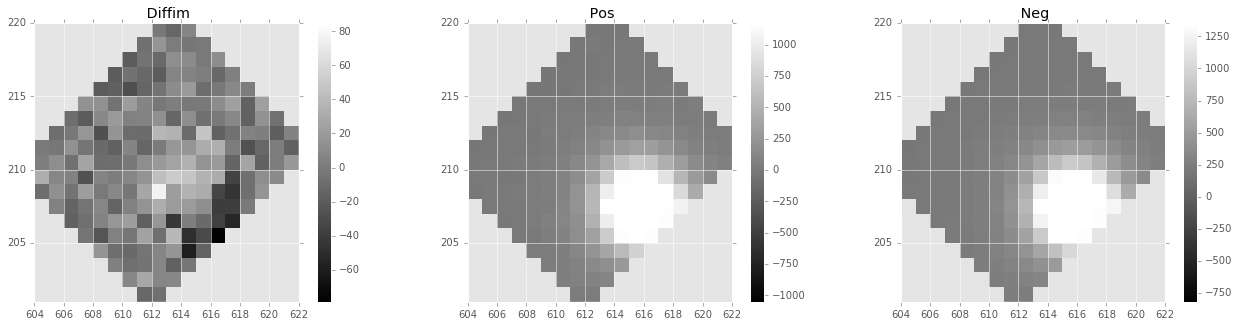

In [81]:
import lsstUtils
reload(lsstUtils)
butler = dp.Butler('decamDirTest2')
sources = butler.get('deepDiff_diaSrc', visit=289820, ccdnum=11)
source = sources[3]
print source.getId()
pks = source.getFootprint().getPeaks()
print len(pks)
fig = lsstUtils.displayCutouts(source, diffim, posImage=posImage, negImage=negImage, asHeavyFootprint=True, 
                               figsize=(22., 5.))